# Sparse Network: MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [30]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")    #category=DeprecationWarning, message='is a deprecated alias'

useSparseNetwork = True
if(useSparseNetwork):
    #set Runtime type = high RAM
    batchSizeMLP = 2048  
    batchSizeCNN = 128  #max value determined by numberOfSparseConvolutionLayers, numberOfchannelsFirstDenseLayer, GPU RAM
    numberOfEpochsMLP = 10  #10
    numberOfEpochsCNN = 10  #10
else:
    batchSizeMLP = 128
    batchSizeCNN = 128
    numberOfEpochsMLP = 20
    numberOfEpochsCNN = 10

learningAlgorithmLUANN = False
onlyTrainFinalLayer = False #initialise dependent var
if(learningAlgorithmLUANN):
    onlyTrainFinalLayer = True

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [32]:
mnist = fetch_openml('mnist_784', cache=False)

In [33]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [34]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [35]:
X /= 255.0

In [36]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [39]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [40]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

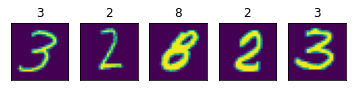

In [41]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [42]:
import torch
from torch import nn
import torch.nn.functional as F

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [45]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [46]:
class MLPModel(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(MLPModel, self).__init__()

        self.isCNNmodel = False

        self.dropout = nn.Dropout(dropout)

        #print("hidden_dim = ", hidden_dim)
        self.numberOfSparseLayers = 1 #default: 1 (1 or 2)
        if(self.numberOfSparseLayers == 1):
            self.numberOfchannelsFirstDenseLayer = 100   #first/dense linear layer   #hidden_dim?
        elif(self.numberOfSparseLayers == 2):
            self.numberOfchannelsFirstDenseLayer = 10    #first/dense linear layer #hidden_dim?
        else:
            print("useSparseNetwork warning: numberOfSparseConvolutionLayers is too high for compute/memory")
            self.numberOfchannelsFirstDenseLayer = 2

        numberOfchannels = self.numberOfchannelsFirstDenseLayer 

        self.linear1 = nn.Linear(input_dim, numberOfchannels)

        self.sparseLayerList = [None]*self.numberOfSparseLayers
        numberOfchannels = self.generateSparseLayers(numberOfchannels, self.sparseLayerList, self.numberOfSparseLayers)

        self.output = nn.Linear(numberOfchannels, output_dim)

    def generateSparseLayers(self, numberOfchannels, sparseLayerList, numberOfSparseLayers):
        for c in range(numberOfSparseLayers):
            #print("c = ", c)
            if(useSparseNetwork):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                #print("numberOfchannels = ", numberOfchannels)
                #print("numChannelPairs = ", numChannelPairs)
                sparseLayerList[c] = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    layer = self.generateLayer(numberOfInputChannels, numberOfOutputChannels)
                    sparseLayerList[c].append(layer)
                if(self.isCNNmodel):
                    self.height, self.width = self.getImageDimensionsAfterConv(self.height, self.width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                if(self.isCNNmodel):
                    #only used by CNN originally:
                    numberOfInputChannels = numberOfchannels
                    numberOfOutputChannels = numberOfchannels*2
                    layer = self.generateLayer(numberOfchannels, numberOfOutputChannels)
                    if(self.isCNNmodel):
                        self.height, self.width = self.getImageDimensionsAfterConv(self.height, self.width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
                    self.sparseConvList[c] = layer
                    numberOfchannels = numberOfOutputChannels

        return numberOfchannels

    def generateLayer(self, numberOfInputChannels, numberOfOutputChannels):
        return self.generateLayerLNN(numberOfInputChannels, numberOfOutputChannels)

    def generateLayerLNN(self, numberOfInputChannels, numberOfOutputChannels):
        layer = nn.Linear(numberOfInputChannels, numberOfOutputChannels)
        return layer

    def forward(self, x, **kwargs):

        #first/dense linear layer
        x = self.linear1(x)
        x = self.activationFunction(x)

        x = self.executeSparseLayers(x)

        if(onlyTrainFinalLayer):
            x = x.detach()

        x = F.softmax(self.output(x), dim=-1)

        return x

    def executeSparseLayers(self, X):

        numberOfchannels = self.numberOfchannelsFirstDenseLayer

        for c in range(self.numberOfSparseLayers):
            if(useSparseNetwork):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                channelsPairsList = self.convertToChannelsToChannelPairsList(X)
                channelPairSublayerOutputList = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    sublayerIn = channelsPairsList[channelPairIndex]
                    sublayerOut = (self.sparseLayerList[c])[channelPairIndex](sublayerIn)
                    sublayerOut = torch.squeeze(sublayerOut, dim=1)   #remove channel dim (size=numberOfOutputChannels=1); prepare for convertChannelPairLINoutputListToChannels execution
                    channelPairSublayerOutputList.append(sublayerOut)
                layerOut = self.convertChannelPairSublayerOutputListToChannels(channelPairSublayerOutputList)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                layerIn = X
                layerOut = (self.sparseLayerList[c])(layerIn)
            layerOut = self.activationFunction(layerOut)
            X = layerOut
        
        return X

    def activationFunction(self, Z):
        A = F.relu(Z)
        A = self.dropout(A)
        return A

    def calculateNumberChannelPairs(self, numInputChannels):
        numChannelPairs = numInputChannels**2
        return numChannelPairs
        #numOutputChannels = number of filters

    def convertToChannelsToChannelPairsList(self, channels):
        res = self.getSublayerTensorProperties(channels)
        batchSize = res[0]
        numberOfchannels = res[1]
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        channelsPairsList = []
        for channelIndex1 in range(numberOfchannels):
            for channelIndex2 in range(numberOfchannels):
                channelPairIndex = channelIndex1*numChannelPairs + channelIndex2
                channelPairSub1 = channels[:, channelIndex1]  #channels[:, channelIndex1, :]
                channelPairSub2 = channels[:, channelIndex2]  #channels[:, channelIndex2, :]
                channelPairSub1 = torch.unsqueeze(channelPairSub1, dim=1)
                channelPairSub2 = torch.unsqueeze(channelPairSub2, dim=1)
                channelPair = torch.cat((channelPairSub1, channelPairSub2), dim=1)
                channelsPairsList.append(channelPair)
        return channelsPairsList

    def getSublayerTensorProperties(self, channels):
       return self.getLINtensorProperties(channels)

    def getLINtensorProperties(self, channels):
        batchSize = channels.shape[0]
        numberOfchannels = channels.shape[1]
        return (batchSize, numberOfchannels)

    def convertChannelPairSublayerOutputListToChannels(self, channelPairSublayerOutputList):
        channels = torch.stack(channelPairSublayerOutputList, dim=1)
        return channels

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [47]:
from skorch import NeuralNetClassifier

In [48]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MLPModel,
    max_epochs=numberOfEpochsMLP,
    lr=0.1,
    device=device,
    batch_size=batchSizeMLP,
)

In [49]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1       11.0062       0.0984       13.6776  132.5101


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLPModel(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=784, out_features=100, bias=True)
    (output): Linear(in_features=10000, out_features=10, bias=True)
  ),
)

## Prediction

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
y_pred = net.predict(X_test)

In [52]:
accuracy_score(y_test, y_pred)

0.09468571428571429

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [53]:
error_mask = y_pred != y_test

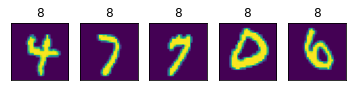

In [54]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [55]:
XCnn = X.reshape(-1, 1, 28, 28)

In [56]:
XCnn.shape

(70000, 1, 28, 28)

In [57]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [58]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [59]:
class CNNModel(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNNModel, self).__init__()

        self.isCNNmodel = True

        self.height = 28 #MNIST defined
        self.width = 28  #MNIST defined
        self.kernelSize = 3
        self.padding = 0
        self.stride = 1
        self.maxPoolSize = 2 #assume max pool at each layer

        self.numberOfSparseLayers = 1 #default: 1 (1 or 2)
        if(self.numberOfSparseLayers == 1):
            self.numberOfchannelsFirstDenseLayer = 32   #first/dense CNN layer
        elif(self.numberOfSparseLayers == 2):
            self.numberOfchannelsFirstDenseLayer = 8    #first/dense CNN layer 
        else:
            print("useSparseNetwork warning: numberOfSparseConvolutionLayers is too high for compute/memory")
            self.numberOfchannelsFirstDenseLayer = 2

        numberOfchannels = self.numberOfchannelsFirstDenseLayer  
        self.conv1 = nn.Conv2d(1, numberOfchannels, kernel_size=self.kernelSize, padding=self.padding, stride=self.stride)
        self.height, self.width = self.getImageDimensionsAfterConv(self.height, self.width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)

        self.sparseLayerList = [None]*self.numberOfSparseLayers
        numberOfchannels = self.generateSparseLayers(numberOfchannels, self.sparseLayerList, self.numberOfSparseLayers)

        firstLinearInputSize = numberOfchannels*self.width*self.height

        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(firstLinearInputSize, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def generateSparseLayers(self, numberOfchannels, sparseLayerList, numberOfSparseLayers):
        for c in range(numberOfSparseLayers):
            #print("c = ", c)
            if(useSparseNetwork):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                #print("numberOfchannels = ", numberOfchannels)
                #print("numChannelPairs = ", numChannelPairs)
                sparseLayerList[c] = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    layer = self.generateLayer(numberOfInputChannels, numberOfOutputChannels)
                    sparseLayerList[c].append(layer)
                if(self.isCNNmodel):
                    self.height, self.width = self.getImageDimensionsAfterConv(self.height, self.width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                if(self.isCNNmodel):
                    #only used by CNN originally:
                    numberOfInputChannels = numberOfchannels
                    numberOfOutputChannels = numberOfchannels*2
                    layer = self.generateLayer(numberOfchannels, numberOfOutputChannels)
                    if(self.isCNNmodel):
                        self.height, self.width = self.getImageDimensionsAfterConv(self.height, self.width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
                    self.sparseConvList[c] = layer
                    numberOfchannels = numberOfOutputChannels

        return numberOfchannels

    def generateLayer(self, numberOfInputChannels, numberOfOutputChannels):
        return self.generateLayerCNN(numberOfInputChannels, numberOfOutputChannels)

    def generateLayerCNN(self, numberOfInputChannels, numberOfOutputChannels):
        layer = nn.Conv2d(numberOfInputChannels, numberOfOutputChannels, kernel_size=self.kernelSize, padding=self.padding, stride=self.stride)
        return layer

    def forward(self, x):

        x = self.conv1(x)
        x = self.activationFunction(x, useDropOut=False)

        x = self.executeSparseLayers(x)

        if(onlyTrainFinalLayer):
            x = x.detach()

        # flatten over channel, height and width
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        return x

    def executeSparseLayers(self, X):

        numberOfchannels = self.numberOfchannelsFirstDenseLayer

        for c in range(self.numberOfSparseLayers):
            if(useSparseNetwork):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                channelsPairsList = self.convertToChannelsToChannelPairsList(X)
                channelPairSublayerOutputList = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    sublayerIn = channelsPairsList[channelPairIndex]
                    sublayerOut = (self.sparseLayerList[c])[channelPairIndex](sublayerIn)
                    sublayerOut = torch.squeeze(sublayerOut, dim=1)   #remove channel dim (size=numberOfOutputChannels=1); prepare for convertChannelPairLINoutputListToChannels execution
                    channelPairSublayerOutputList.append(sublayerOut)
                layerOut = self.convertChannelPairSublayerOutputListToChannels(channelPairSublayerOutputList)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                layerIn = X
                layerOut = (self.sparseLayerList[c])(layerIn)
            layerOut = self.activationFunction(layerOut)
            X = layerOut
        
        return X

    def activationFunction(self, Z, useDropOut=True):
        if(useDropOut):
            Z = self.conv2_drop(Z)
        A = torch.relu(F.max_pool2d(Z, kernel_size=self.maxPoolSize))
        return A

    def getImageDimensionsAfterConv(self, inputHeight, inputWidth, kernelSize, padding, stride, maxPoolSize):
        height = (inputHeight - (kernelSize//2 * 2) + padding) // stride // maxPoolSize    #// = integer floor division
        width = (inputWidth - (kernelSize//2 * 2) + padding) // stride // maxPoolSize
        return height, width

    def calculateNumberChannelPairs(self, numInputChannels):
        numChannelPairs = numInputChannels**2
        return numChannelPairs
        #numOutputChannels = number of filters

    def convertToChannelsToChannelPairsList(self, channels):
        res = self.getSublayerTensorProperties(channels)
        batchSize = res[0]
        numberOfchannels = res[1]
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        channelsPairsList = []
        for channelIndex1 in range(numberOfchannels):
            for channelIndex2 in range(numberOfchannels):
                channelPairIndex = channelIndex1*numChannelPairs + channelIndex2
                channelPairSub1 = channels[:, channelIndex1]  #channels[:, channelIndex1, :, :]
                channelPairSub2 = channels[:, channelIndex2]  #channels[:, channelIndex1, :, :]
                channelPairSub1 = torch.unsqueeze(channelPairSub1, dim=1)
                channelPairSub2 = torch.unsqueeze(channelPairSub2, dim=1)
                channelPair = torch.cat((channelPairSub1, channelPairSub2), dim=1)
                channelsPairsList.append(channelPair)
        return channelsPairsList

    def getSublayerTensorProperties(self, channels):
       return self.getCNNtensorProperties(channels)

    def getCNNtensorProperties(self, channels):
        batchSize = channels.shape[0]
        numberOfchannels = channels.shape[1]
        height = channels.shape[2]
        width = channels.shape[3]
        return (batchSize, numberOfchannels, height, width)

    def convertChannelPairSublayerOutputListToChannels(self, channelPairSublayerOutputList):
        channels = torch.stack(channelPairSublayerOutputList, dim=1)
        return channels
     

In [60]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    CNNModel,
    max_epochs=numberOfEpochsCNN,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=batchSizeCNN,
)

In [61]:
cnn.fit(XCnn_train, y_train)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.6532       0.9006        0.6801  830.8997


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNNModel(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=25600, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

In [62]:
y_pred_cnn = cnn.predict(XCnn_test)

In [63]:
accuracy_score(y_test, y_pred_cnn)

0.9005714285714286

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [64]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.9176923562456606

Over 70% of the previously misclassified images are now correctly identified.

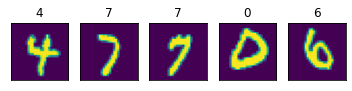

In [65]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])